In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%cd '/content/drive/My Drive/224_augmented_folder'


/content/drive/.shortcut-targets-by-id/1R60y6ct3H-9s5gYwmKLHRWBXwTIU2OGK/224_augmented_folder


In [ ]:
!pip install tensorflow
!pip install tensorflow-hub
!pip install matplotlib

In [ ]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
def count_images(folder_path):
    image_extensions = {'.png', '.jpg', '.jpeg', '.bmp', '.gif'}
    image_count = 0
    for root, _, files in os.walk(folder_path):
        for file in files:
            if os.path.splitext(file)[-1].lower() in image_extensions:
                image_count += 1
    return image_count

train_path = '/content/drive/My Drive/224_augmented_folder/train'
valid_path = '/content/drive/My Drive/224_augmented_folder/valid'
test_path = '/content/drive/My Drive/224_augmented_folder/test'

train_image_count = count_images(train_path)
valid_image_count = count_images(valid_path)
test_image_count = count_images(test_path)

print(f"Train images: {train_image_count}")
print(f"Validation images: {valid_image_count}")
print(f"Test images: {test_image_count}")


Train images: 2953
Validation images: 280
Test images: 140


In [ ]:

# Paths to your dataset folders
train_path = '/content/drive/My Drive/224_augmented_folder/train'
valid_path = '/content/drive/My Drive/224_augmented_folder/valid'
test_path = '/content/drive/My Drive/224_augmented_folder/test'

# Create ImageDataGenerator instances without validation_split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow from directories
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 2953 images belonging to 7 classes.
Found 280 images belonging to 7 classes.
Found 140 images belonging to 7 classes.


In [ ]:
# Load Vision Transformer model from TensorFlow Hub
vit_model = Sequential([
    hub.KerasLayer("https://tfhub.dev/sayakpaul/vit_b16_fe/1", trainable=False),
    layers.Flatten(),
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='sigmoid')  # Adjust number of output classes (7 for your case)
])

# Define the learning rate schedule
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

vit_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])



# Define callbacks for learning rate adjustment and model saving
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
  #Functionality: During training, if the validation loss does not improve for a specified number of epochs (patience), the learning rate is reduced (factor times the current learning rate) to help the model converge more effectively.
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Marine_Debris_Monitoring_Tool/chck01_marine_debris_vit_model',
                                                      save_best_only=True)
  #This callback saves the model checkpoints (i.e., model weights) during training.




# Train the model
history = vit_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[reduce_lr, model_checkpoint]
)

#evaluation
test_loss, test_acc = vit_model.evaluate(test_generator, verbose=2)
print(f"Test Accuracy: {test_acc}")





Epoch 1/50
92/92 [==============================] - 1153s 12s/step - loss: 0.1753 - accuracy: 0.8518 - val_loss: 0.0187 - val_accuracy: 0.9883 - lr: 0.0010
Epoch 2/50
92/92 [==============================] - 72s 784ms/step - loss: 0.0554 - accuracy: 0.9531 - val_loss: 0.0128 - val_accuracy: 0.9922 - lr: 0.0010
Epoch 3/50
92/92 [==============================] - 73s 790ms/step - loss: 0.0370 - accuracy: 0.9723 - val_loss: 0.0112 - val_accuracy: 0.9961 - lr: 0.0010
Epoch 4/50
92/92 [==============================] - 73s 793ms/step - loss: 0.0294 - accuracy: 0.9801 - val_loss: 0.0095 - val_accuracy: 0.9961 - lr: 0.0010
Epoch 5/50
92/92 [==============================] - 75s 812ms/step - loss: 0.0248 - accuracy: 0.9822 - val_loss: 0.0072 - val_accuracy: 0.9961 - lr: 0.0010
Epoch 6/50
92/92 [==============================] - 60s 655ms/step - loss: 0.0195 - accuracy: 0.9863 - val_loss: 0.0095 - val_accuracy: 0.9961 - lr: 0.0010
Epoch 7/50
92/92 [==============================] - 61s 663ms/st

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='bottom right')

plt.show()



In [ ]:
vit_model.save('/content/drive/My Drive/Marine_Debris_Monitoring_Tool/marine_vit_model')


In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model_path = '/content/drive/My Drive/Marine_Debris_Monitoring_Tool/marine_vit_model'
vit_model = load_model(model_path, custom_objects={'KerasLayer': hub.KerasLayer})


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Load image and resize
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Rescale image
    return img_array


In [ ]:
def predict_image(img_path):
    preprocessed_image = preprocess_image(img_path)
    prediction = vit_model.predict(preprocessed_image)
    return prediction

# Example usage
new_image_path = '/content/drive/My Drive/11451343-large.jpg'  # Path to your new image
prediction = predict_image(new_image_path)
print(prediction)


1/1 [==============================] - 0s 35ms/step
[[3.9501272e-05 1.3801174e-03 6.8013757e-01 6.4095316e-06 4.1693125e-05
  1.1335894e-02 4.3848795e-03]]


{'Bag': 0, 'Bottle': 1, 'Bucket': 1, 'Fish': 0, 'Net': 0, 'Straw': 1, 'Wrapping': 1}


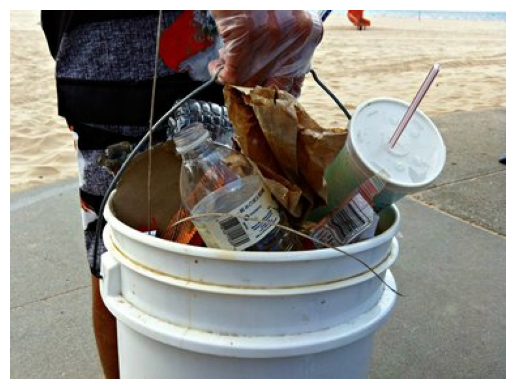

In [ ]:
def interpret_prediction(prediction, class_labels, threshold=0.05):
    predicted_labels = (prediction > threshold).astype(int)
    result = {class_labels[i]: predicted_labels[0][i] for i in range(len(class_labels))}
    return result

# Example class labels
class_labels = ['Bag', 'Bottle', 'Bucket', 'Fish', 'Net', 'Straw', 'Wrapping']

interpreted_result = interpret_prediction(prediction, class_labels)
print(interpreted_result)

# Display the image
def display_image(img_path):
    img = image.load_img(img_path)  # Load image
    plt.imshow(img)  # Display image
    plt.axis('off')  # Hide axes
    plt.show()

# Display the uploaded image
display_image(new_image_path)
